In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

In [87]:
# 1) Load Training Dataset
train_df = pd.read_csv("regt1.csv")

In [89]:
# Features & target
features = ["completion_ratio", "avg_difficulty", "locality_rating", "citizen_rating"]
X = train_df[features].values
y = train_df["feature_score"].values  # continuous target now

In [91]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [93]:
# 2) Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [94]:
# 3) Train RandomForest Regressor
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_s, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [96]:
# 4) Load Prediction Dataset
pred_df = pd.read_csv("regp1.csv")

In [99]:
# Fix completion_ratio just in case
pred_df["completion_ratio"] = (pred_df["tasks_completed"] / pred_df["tasks_assigned"]).clip(0,1)

X_pred = pred_df[features].values
X_pred_s = scaler.transform(X_pred)

In [101]:
# 5) Predict continuous score
pred_df["predicted_score"] = rf.predict(X_pred_s)

In [103]:
# 6) Optional: Map to Low/Medium/High
def label_from_score(s):
    if s >= 0.7:
        return "High"
    elif s >= 0.4:
        return "Medium"
    else:
        return "Low"

pred_df["pred_label"] = pred_df["predicted_score"].apply(label_from_score)

In [105]:
# 7) Leaderboard: sort by predicted_score
leaderboard = pred_df.sort_values("predicted_score", ascending=False).reset_index(drop=True)

In [107]:
# 8) Show top 10 workers
print("\n Worker Leaderboard ")
print(leaderboard[["worker_id", "completion_ratio", "avg_difficulty",
                   "locality_rating", "citizen_rating", "predicted_score", "pred_label"]])


 Worker Leaderboard 
     worker_id  completion_ratio  avg_difficulty  locality_rating  \
0           44          1.000000               5                4   
1          128          0.750000               5                5   
2           85          0.800000               5                5   
3          112          0.789474               5                5   
4           79          0.687500               5                4   
..         ...               ...             ...              ...   
145         83          0.000000               2                2   
146         84          0.052632               1                5   
147         95          0.000000               1                5   
148        127          0.000000               1                5   
149        137          0.000000               1                1   

     citizen_rating  predicted_score pred_label  
0                 2         0.880103       High  
1                 5         0.859087       High  

In [109]:
# 9) Save leaderboard to CSV
leaderboard.to_csv("regl1.csv", index=False)
print("\nLeaderboard saved -> regl1.csv")


Leaderboard saved -> regl1.csv


In [111]:
# Single Worker Prediction
# Enter the worker's features here:
manual_worker = pd.DataFrame([{
    "completion_ratio": 1.0,   # 0 to 1
    "avg_difficulty": 5,       # 1 to 5
    "locality_rating": 5,      # 1 to 5
    "citizen_rating": 5        # 1 to 5
}])

# Scale features using the same scaler as training
manual_worker_s = scaler.transform(manual_worker[features])

# Predict feature score
manual_worker["predicted_score"] = rf.predict(manual_worker_s)

# Map to Low/Medium/High (optional)
def label_from_score(s):
    if s >= 0.7:
        return "High"
    elif s >= 0.4:
        return "Medium"
    else:
        return "Low"

manual_worker["pred_label"] = manual_worker["predicted_score"].apply(label_from_score)

print("\nSingle Worker Prediction:")
print(manual_worker)


Single Worker Prediction:
   completion_ratio  avg_difficulty  locality_rating  citizen_rating  \
0               1.0               5                5               5   

   predicted_score pred_label  
0         0.985697       High  


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



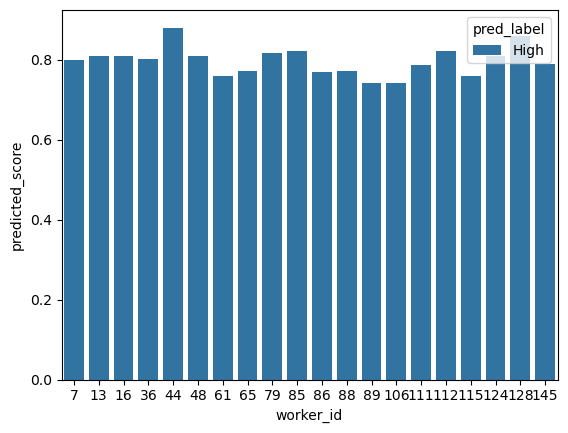

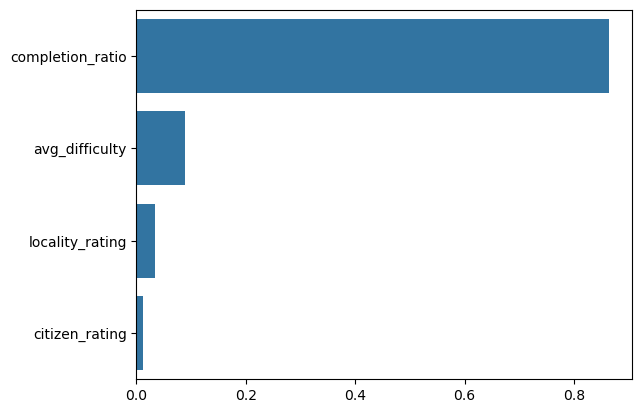

In [61]:
# Matplotlib / Seaborn visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Top 20 leaderboard bar chart
top_workers = leaderboard.head(20)
sns.barplot(x="worker_id", y="predicted_score", data=top_workers, hue="pred_label")
plt.show()

# Feature importance
importances = rf.feature_importances_
sns.barplot(x=importances, y=features)
plt.show()

In [63]:
pip install dash dash-bootstrap-components plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


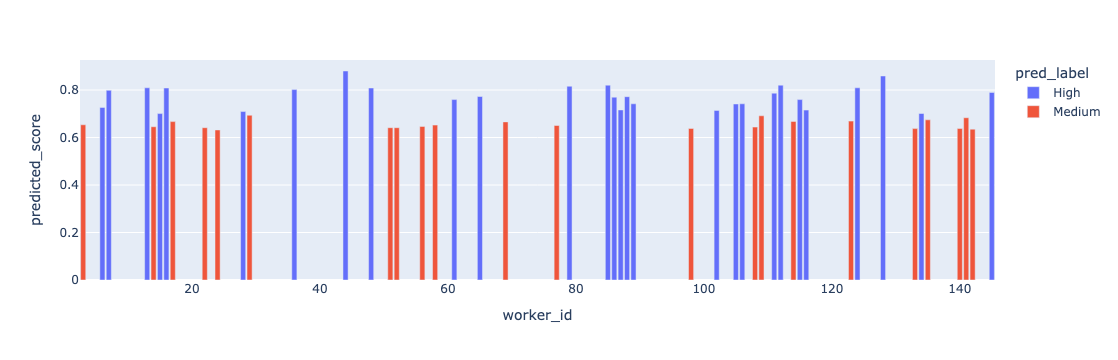

In [67]:
# Plotly interactive visualizations
import plotly.express as px

# Example: Top 50 workers bar chart
fig = px.bar(leaderboard.head(50), x="worker_id", y="predicted_score", color="pred_label",
             hover_data=features)
fig.show()

# Dash interactive dashboard 

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# -----------------------------
# Initialize Dash app
# -----------------------------
app = dash.Dash(__name__)

# -----------------------------
# Layout
# -----------------------------
app.layout = html.Div([
    html.H1("Worker Leaderboard Dashboard", style={"textAlign": "center"}),

    html.Div([
        html.Label("Filter by Predicted Label:"),
        dcc.Dropdown(
            id="label_filter",
            options=[
                {"label": "All", "value": "All"},
                {"label": "High", "value": "High"},
                {"label": "Medium", "value": "Medium"},
                {"label": "Low", "value": "Low"}
            ],
            value="All",
            clearable=False
        )
    ], style={"width":"30%", "margin":"20px"}),

    dcc.Tabs([
        dcc.Tab(label="Top Workers", children=[
            dcc.Graph(id="bar_leaderboard")
        ]),
        dcc.Tab(label="Completion vs Score", children=[
            dcc.Graph(id="scatter_completion")
        ]),
        dcc.Tab(label="Difficulty vs Score", children=[
            dcc.Graph(id="scatter_difficulty")
        ]),
        dcc.Tab(label="Locality vs Citizen", children=[
            dcc.Graph(id="bubble_locality_citizen")
        ])
    ])
])

# -----------------------------
# Callbacks to update plots
# -----------------------------
@app.callback(
    [Output("bar_leaderboard", "figure"),
     Output("scatter_completion", "figure"),
     Output("scatter_difficulty", "figure"),
     Output("bubble_locality_citizen", "figure")],
    [Input("label_filter", "value")]
)
def update_graphs(selected_label):
    if selected_label != "All":
        df_filtered = leaderboard[leaderboard["pred_label"] == selected_label]
    else:
        df_filtered = leaderboard.copy()

    # Bar chart - Top 20 workers
    bar_fig = px.bar(
        df_filtered.head(20),
        x="worker_id",
        y="predicted_score",
        color="pred_label",
        hover_data=["completion_ratio", "avg_difficulty", "locality_rating", "citizen_rating"],
        title="Top 20 Workers by Predicted Score"
    )

    # Scatter - Completion vs Predicted Score
    scatter_completion = px.scatter(
        df_filtered,
        x="completion_ratio",
        y="predicted_score",
        color="pred_label",
        hover_data=["worker_id", "avg_difficulty", "locality_rating", "citizen_rating"],
        title="Completion Ratio vs Predicted Score",
        size="avg_difficulty"
    )

    # Scatter - Difficulty vs Predicted Score
    scatter_difficulty = px.scatter(
        df_filtered,
        x="avg_difficulty",
        y="predicted_score",
        color="pred_label",
        hover_data=["worker_id", "completion_ratio", "locality_rating", "citizen_rating"],
        title="Difficulty vs Predicted Score",
        size="completion_ratio"
    )

    # Bubble - Locality vs Citizen Ratings
    bubble_fig = px.scatter(
        df_filtered,
        x="locality_rating",
        y="citizen_rating",
        color="pred_label",
        size="predicted_score",
        hover_data=["worker_id", "completion_ratio", "avg_difficulty"],
        title="Locality vs Citizen Rating (Bubble size = Predicted Score)"
    )

    return bar_fig, scatter_completion, scatter_difficulty, bubble_fig

# -----------------------------
# Run Dash app
# -----------------------------
if __name__ == "__main__":
    app.run(debug=True)

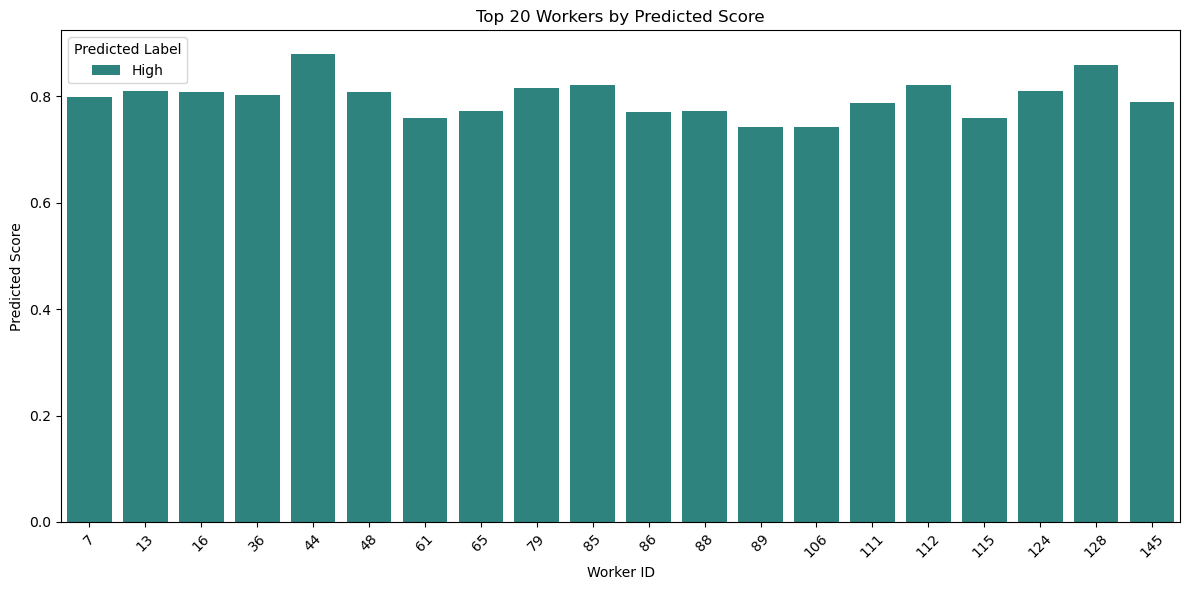

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 20 workers by predicted_score
top_workers = leaderboard.head(20)

plt.figure(figsize=(12,6))
sns.barplot(x="worker_id", y="predicted_score", data=top_workers, hue="pred_label", dodge=False, palette="viridis")
plt.title("Top 20 Workers by Predicted Score")
plt.xlabel("Worker ID")
plt.ylabel("Predicted Score")
plt.xticks(rotation=45)
plt.legend(title="Predicted Label")
plt.tight_layout()
plt.show()

/var/folders/hf/gff06d0x1sx3l7ynv13gpv100000gn/T/ipykernel_32474/1349302087.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




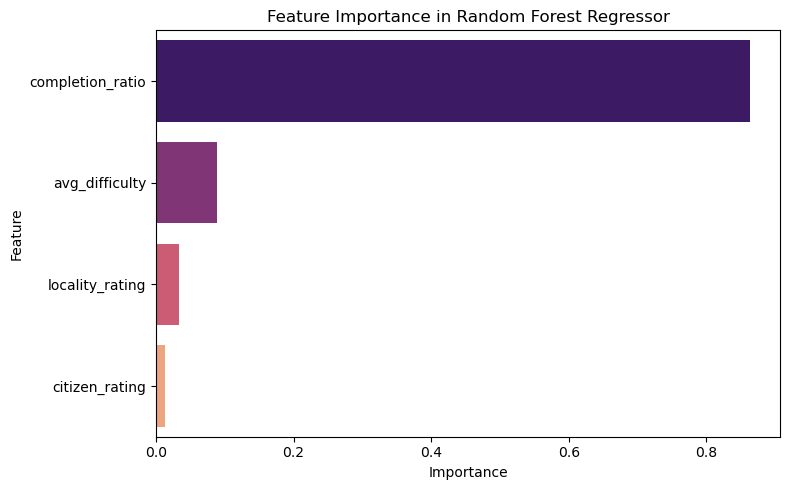

In [71]:
importances = rf.feature_importances_
feature_names = features

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names, palette="magma")
plt.title("Feature Importance in Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

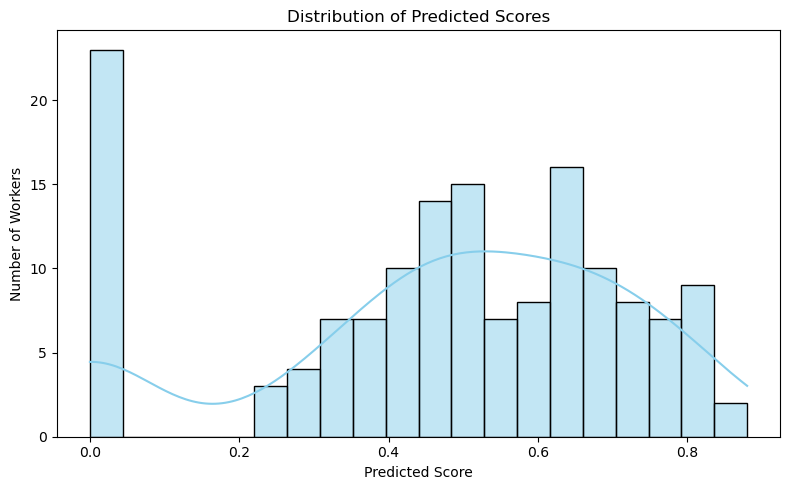

In [73]:
plt.figure(figsize=(8,5))
sns.histplot(leaderboard["predicted_score"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Predicted Scores")
plt.xlabel("Predicted Score")
plt.ylabel("Number of Workers")
plt.tight_layout()
plt.show()

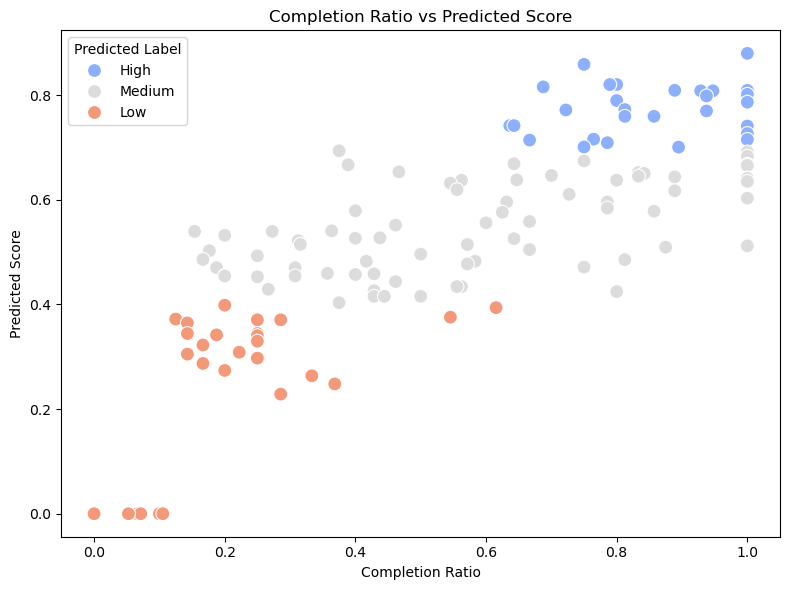

In [75]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="completion_ratio", y="predicted_score", data=leaderboard, hue="pred_label", palette="coolwarm", s=100)
plt.title("Completion Ratio vs Predicted Score")
plt.xlabel("Completion Ratio")
plt.ylabel("Predicted Score")
plt.legend(title="Predicted Label")
plt.tight_layout()
plt.show()

/var/folders/hf/gff06d0x1sx3l7ynv13gpv100000gn/T/ipykernel_32474/2157257785.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




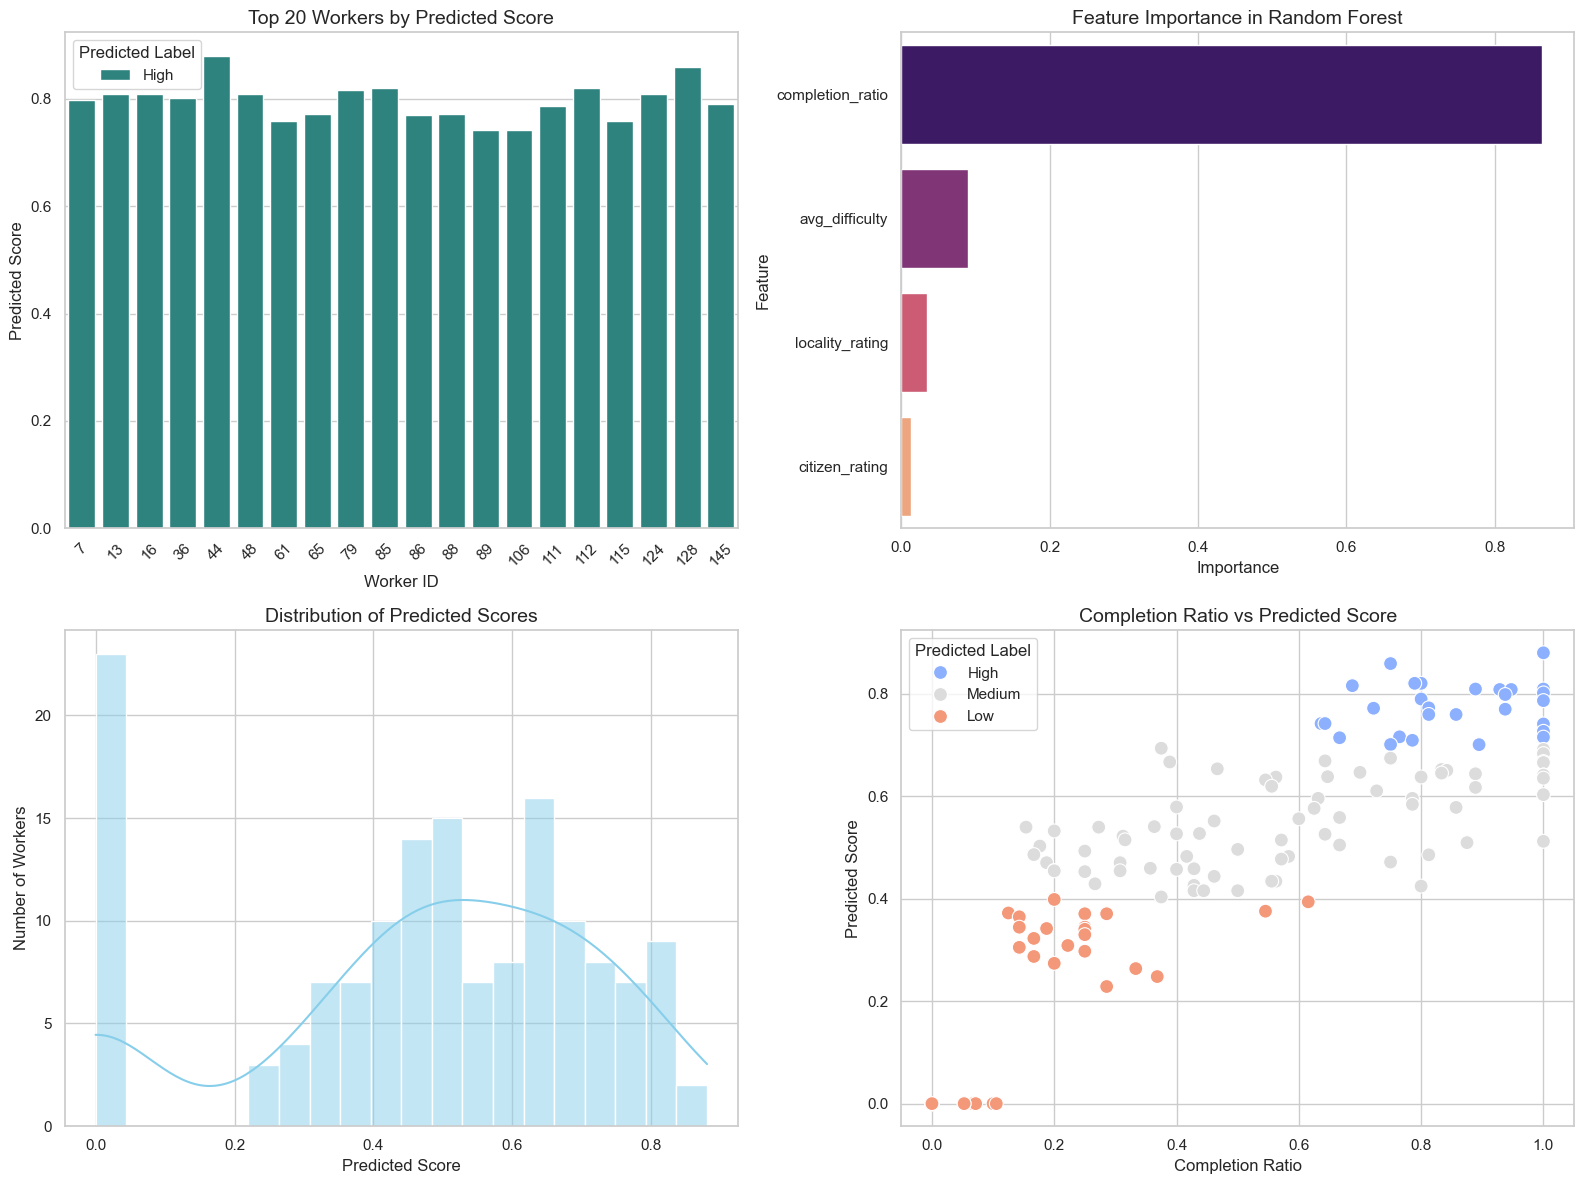

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# 1) Top 20 Workers Leaderboard
# -----------------------------
top_workers = leaderboard.head(20)
sns.barplot(x="worker_id", y="predicted_score", data=top_workers, hue="pred_label",
            dodge=False, palette="viridis", ax=axes[0,0])
axes[0,0].set_title("Top 20 Workers by Predicted Score", fontsize=14)
axes[0,0].set_xlabel("Worker ID")
axes[0,0].set_ylabel("Predicted Score")
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend(title="Predicted Label")

# -----------------------------
# 2) Feature Importance
# -----------------------------
importances = rf.feature_importances_
sns.barplot(x=importances, y=features, palette="magma", ax=axes[0,1])
axes[0,1].set_title("Feature Importance in Random Forest", fontsize=14)
axes[0,1].set_xlabel("Importance")
axes[0,1].set_ylabel("Feature")

# -----------------------------
# 3) Predicted Score Distribution
# -----------------------------
sns.histplot(leaderboard["predicted_score"], bins=20, kde=True, color="skyblue", ax=axes[1,0])
axes[1,0].set_title("Distribution of Predicted Scores", fontsize=14)
axes[1,0].set_xlabel("Predicted Score")
axes[1,0].set_ylabel("Number of Workers")

# -----------------------------
# 4) Completion Ratio vs Predicted Score
# -----------------------------
sns.scatterplot(x="completion_ratio", y="predicted_score", data=leaderboard,
                hue="pred_label", palette="coolwarm", s=100, ax=axes[1,1])
axes[1,1].set_title("Completion Ratio vs Predicted Score", fontsize=14)
axes[1,1].set_xlabel("Completion Ratio")
axes[1,1].set_ylabel("Predicted Score")
axes[1,1].legend(title="Predicted Label")

plt.tight_layout()
plt.show()

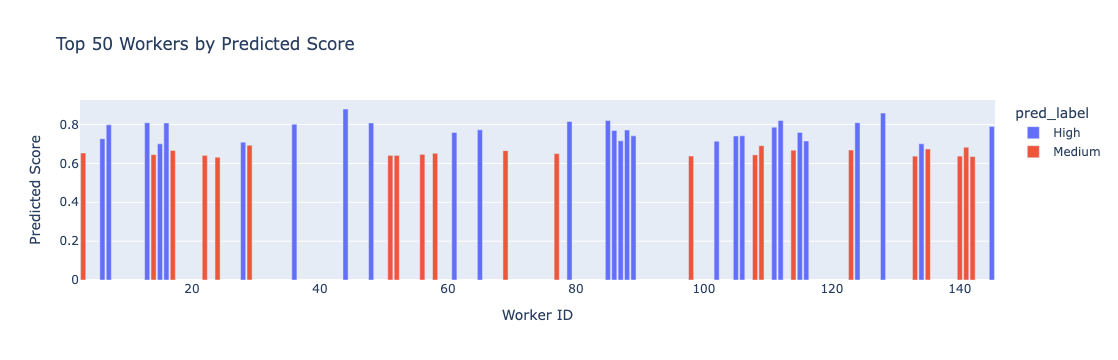

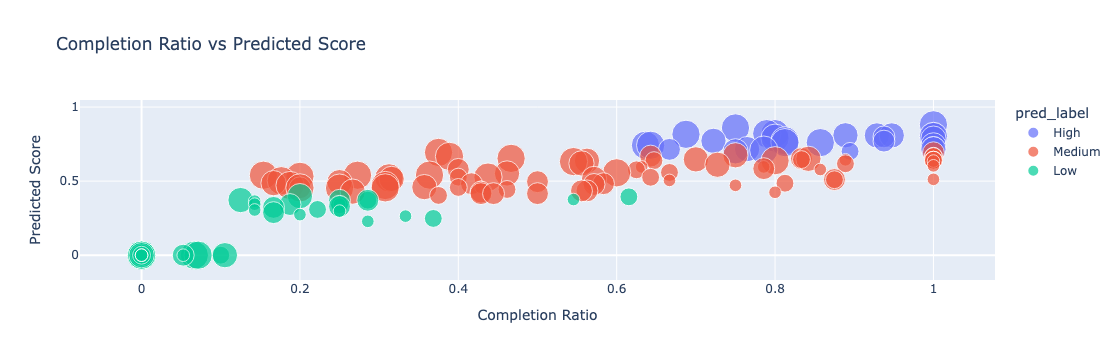

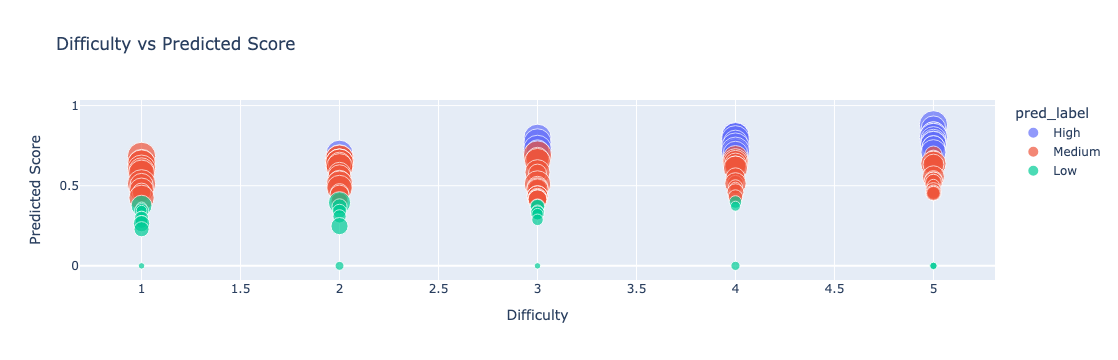

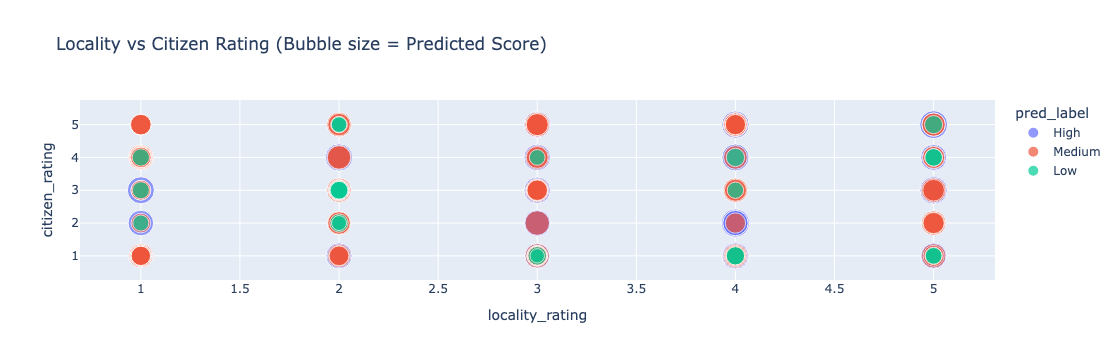

In [79]:
import plotly.express as px

# -----------------------------
# 1) Interactive Leaderboard (Top 50 workers)
# -----------------------------
top_workers = leaderboard.head(50)
fig1 = px.bar(
    top_workers,
    x="worker_id",
    y="predicted_score",
    color="pred_label",
    hover_data=["completion_ratio", "avg_difficulty", "locality_rating", "citizen_rating"],
    title="Top 50 Workers by Predicted Score",
    labels={"worker_id":"Worker ID", "predicted_score":"Predicted Score"}
)
fig1.show()

# -----------------------------
# 2) Completion Ratio vs Predicted Score
# -----------------------------
fig2 = px.scatter(
    leaderboard,
    x="completion_ratio",
    y="predicted_score",
    color="pred_label",
    hover_data=["worker_id", "avg_difficulty", "locality_rating", "citizen_rating"],
    title="Completion Ratio vs Predicted Score",
    labels={"completion_ratio":"Completion Ratio", "predicted_score":"Predicted Score"},
    size="avg_difficulty",  # optional: size by difficulty
)
fig2.show()

# -----------------------------
# 3) Difficulty vs Predicted Score
# -----------------------------
fig3 = px.scatter(
    leaderboard,
    x="avg_difficulty",
    y="predicted_score",
    color="pred_label",
    hover_data=["worker_id", "completion_ratio", "locality_rating", "citizen_rating"],
    title="Difficulty vs Predicted Score",
    labels={"avg_difficulty":"Difficulty", "predicted_score":"Predicted Score"},
    size="completion_ratio",
)
fig3.show()

# -----------------------------
# 4) Locality vs Citizen Ratings (Bubble plot)
# -----------------------------
fig4 = px.scatter(
    leaderboard,
    x="locality_rating",
    y="citizen_rating",
    color="pred_label",
    size="predicted_score",
    hover_data=["worker_id", "completion_ratio", "avg_difficulty"],
    title="Locality vs Citizen Rating (Bubble size = Predicted Score)",
)
fig4.show()

In [83]:
import joblib
joblib.dump(rf, "worker_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved as worker_model.pkl & scaler.pkl")

✅ Model and scaler saved as worker_model.pkl & scaler.pkl
